<table>
<tr>
<td>  <img  src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true "style="width: 300px;padding: 40px"/>
</td>
<td> 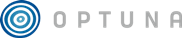 </td>
</tr></table>
<div align="center"> 
<hr>
<font size="3">Hyper-Parameter Tuning with Optuna Tutorial</font>
</div>
<hr>

Optimization and fine-tuning for the hyper-parameters using a novel framework named Optuna.

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
!pip install pyjedai

In [ ]:
!pip show pyjedai

Imports

In [1]:
import plotly.express as px
import logging
import sys
import optuna
import plotly
import os
import sys
import pandas as pd
from optuna.visualization import *
import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"

## Data Reading

In [4]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./../data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./../data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./../data/D2/gt.csv", sep='|', engine='python'),
)

data.process()

## WorkFlow

In [5]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [6]:
db_name = "pyjedai"
title = "Test"
storage_name = "sqlite:///{}.db".format(db_name)
study_name = title  # Unique identifier of the study.

In [20]:
'''
 OPTUNA objective function
'''
def objective(trial):
    
    w = WorkFlow(
        block_building = dict(
            method=QGramsBlocking, 
            params=dict(qgrams=trial.suggest_int("qgrams", 3, 10)),
            attributes_1=['name'],
            attributes_2=['name']
        ),
        block_cleaning = [
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            ),
            dict(
                method=BlockFiltering, 
                params=dict(
                    ratio = trial.suggest_float("ratio", 0.7, 0.95)
                )
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
            entity_matching = dict(
            method=EntityMatching, 
            metric='sorensen_dice',
            similarity_threshold= trial.suggest_float("similarity_threshold", 0.05, 0.9),
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Worflow-Test"
    )
    w.run(data, tqdm_disable=True, verbose=False)
    f1, precision, recall = w.get_final_scores()
    
    return f1

In [22]:
study_name = title  # Unique identifier of the study.
num_of_trials = 30
study = optuna.create_study(
    directions=["maximize"],
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)
print("Optuna trials starting")
study.optimize(
    objective, 
    n_trials=num_of_trials, 
    show_progress_bar=True
)
print("Optuna trials finished")

[I 2022-09-26 11:55:42,802] A new study created in RDB with name: Test


Optuna trials starting


C:\Users\nikol\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-26 11:55:46,023] Trial 0 finished with value: 0.41623748332517185 and parameters: {'qgrams': 9, 'ratio': 0.7064477341952005, 'similarity_threshold': 0.6055581611542903}. Best is trial 0 with value: 0.41623748332517185.
[I 2022-09-26 11:55:52,643] Trial 1 finished with value: 0.21238254601621828 and parameters: {'qgrams': 6, 'ratio': 0.882284882762086, 'similarity_threshold': 0.37289148137989997}. Best is trial 0 with value: 0.41623748332517185.
[I 2022-09-26 11:56:02,835] Trial 2 finished with value: 0.19160380037946811 and parameters: {'qgrams': 4, 'ratio': 0.7430841447768943, 'similarity_threshold': 0.5972081281433346}. Best is trial 0 with value: 0.41623748332517185.
[I 2022-09-26 11:56:16,769] Trial 3 finished with value: 0.19139437478579407 and parameters: {'qgrams': 4, 'ratio': 0.9028269915131414, 'similarity_threshold': 0.6205555792138078}. Best is trial 0 with value: 0.41623748332517185.
[I 2022-09-26 11:56:21,090] Trial 4 finished with value: 0.40135069171727084 and

# Optuna Visualizations

In [23]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

,number,value,params_qgrams,params_ratio,params_similarity_threshold,state
0,0,0.416237,9,0.706448,0.605558,COMPLETE
1,1,0.212383,6,0.882285,0.372891,COMPLETE
2,2,0.191604,4,0.743084,0.597208,COMPLETE
3,3,0.191394,4,0.902827,0.620556,COMPLETE
4,4,0.401351,9,0.765792,0.794723,COMPLETE
5,5,0.189586,4,0.913062,0.154663,COMPLETE
6,6,0.196681,5,0.891483,0.322687,COMPLETE
7,7,0.205232,5,0.737635,0.296116,COMPLETE
8,8,0.322596,8,0.947709,0.224764,COMPLETE
9,9,0.272363,7,0.737370,0.503203,COMPLETE


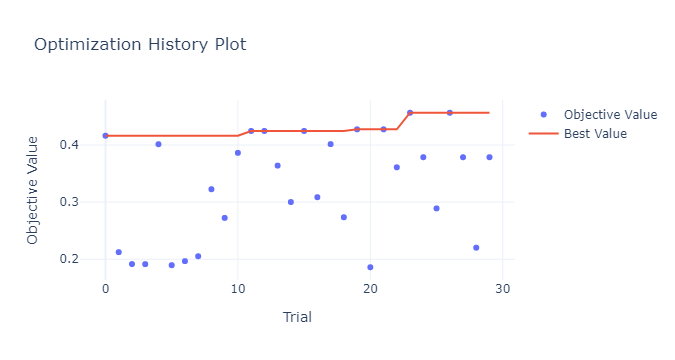

In [24]:
fig = plot_optimization_history(study)
fig.show()

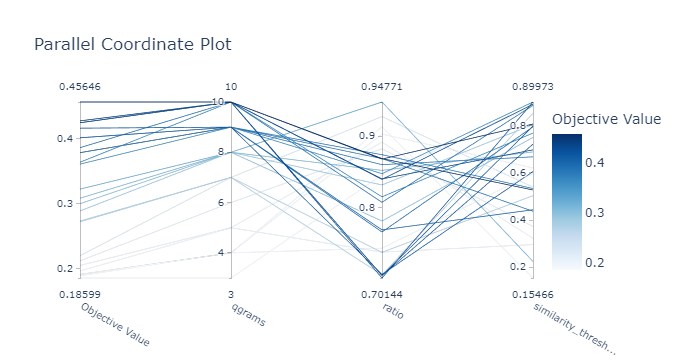

In [25]:
fig = plot_parallel_coordinate(study)
fig.show()

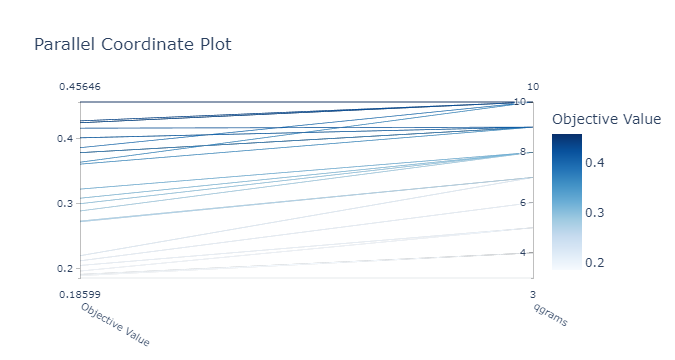

In [26]:
fig = plot_parallel_coordinate(study, params=["qgrams"])
fig.show()

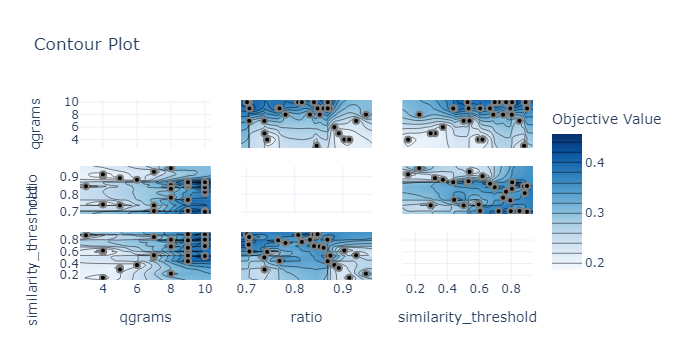

In [27]:
fig = plot_contour(study)
fig.show()

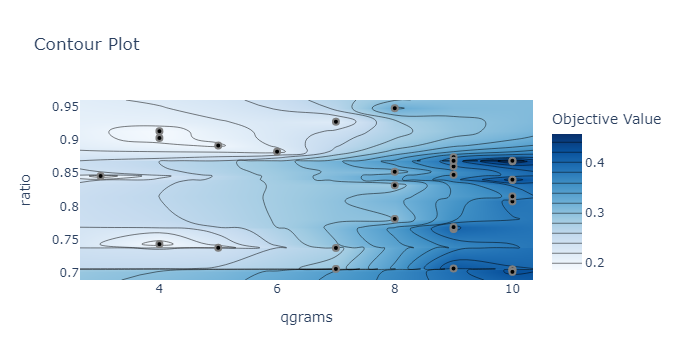

In [28]:
fig = plot_contour(study, params=["qgrams", "ratio"])
fig.show()

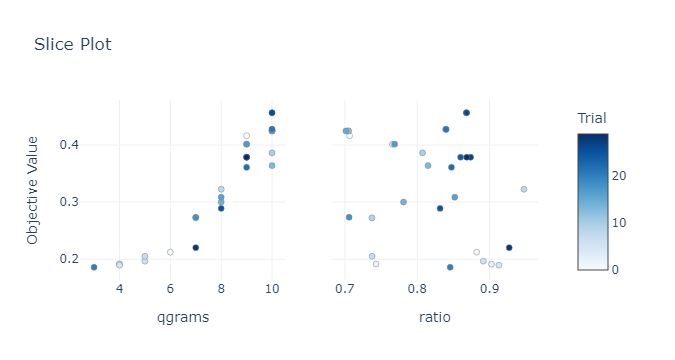

In [29]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

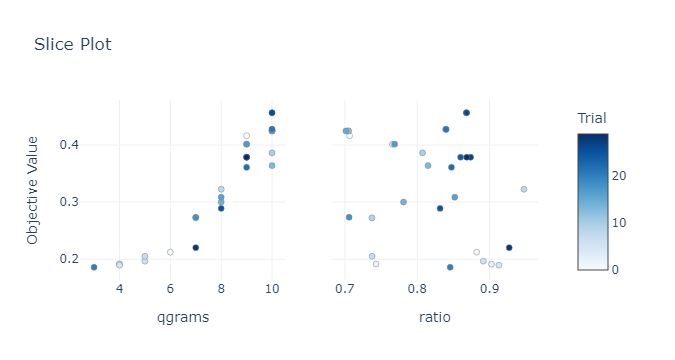

In [30]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

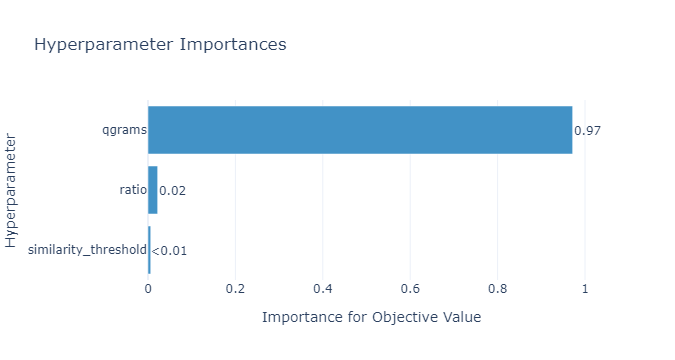

In [31]:
fig = plot_param_importances(study)
fig.show()

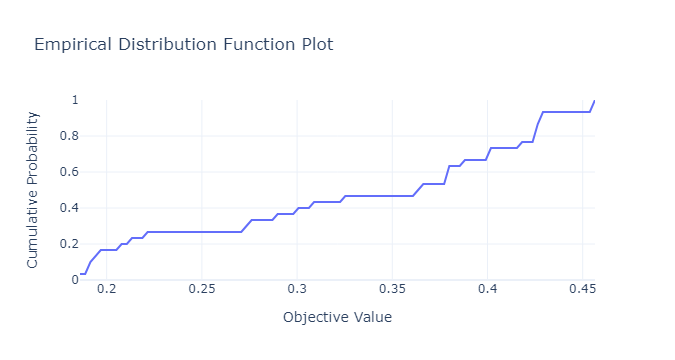

In [32]:
fig = plot_edf(study)
fig.show()

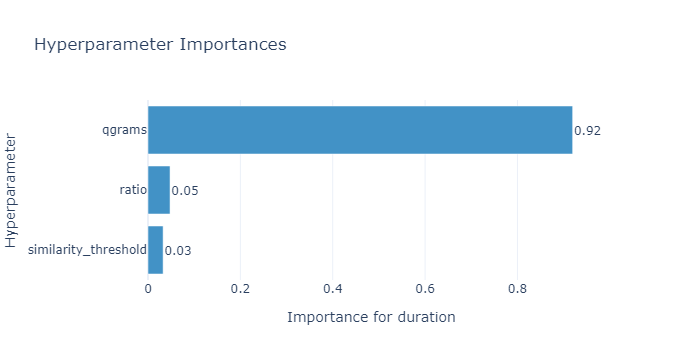

In [33]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)
fig.show()